# LAYERS
# 2nd Approach - Relative Maximums and Minimums

This approach uses the relative maximums and minimums to determine the different layers of the vertical profile. The relative maximums and minimums are located where the first derivative is equal to zero

In [1]:
#First, some imports
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotting_functions as plot

#Now we read the data
from read_CTD import read_CTD
data_dirs = ['C:/Users/Pau/Data/TFM/CTD_proc_files_1mbin/']
data=read_CTD(data_dirs)

#And delete the outliers
from out_outliers import out_outliers
for ncast in data.keys():
    for variable in data[ncast].columns:
        out_outliers(data, ncast, variable)

[]

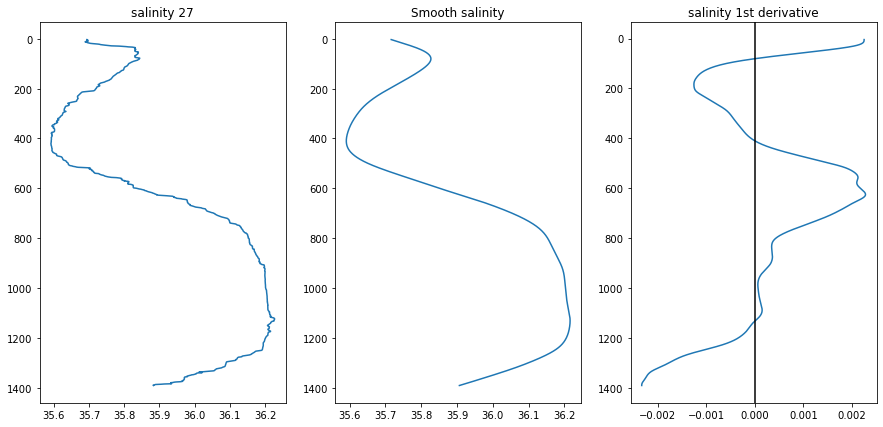

In [2]:
#2nd approach - Layer determination using the profile relative maximums and minimums
#Test with profile ncast=27
ncast = '27'
#Smooth the profile
variable = 'salinity'
lamb = 500000    #Smooth exageration
var_ciclo, var_tend = sm.tsa.filters.hpfilter(data[ncast][variable],lamb=lamb)

#Calculate the 1st derivative of the smooth profile
der1_var_tend = np.diff(var_tend, n=1)

#Plot the vertical profiles and the 1st derivative
fig, (ax0, ax1, ax2) = plt.subplots(1,3, figsize=(15,7))
ax0.plot(data[ncast][variable], data[ncast].index)
ax0.invert_yaxis()
ax0.set_title(variable+' '+ncast)
ax1.plot(var_tend, var_tend.index)
ax1.invert_yaxis()
ax1.set_title('Smooth '+variable)
ax2.plot(der1_var_tend, var_tend.index[1:])
ax2.axvline(x=0, c='black')
ax2.invert_yaxis()
ax2.set_title(variable+' 1st derivative')
plt.plot()

there are  3  relative maximums and minimums in the next depths
[80.13, 409.0375, 1131.2205]
Profile 27 has 4 layers


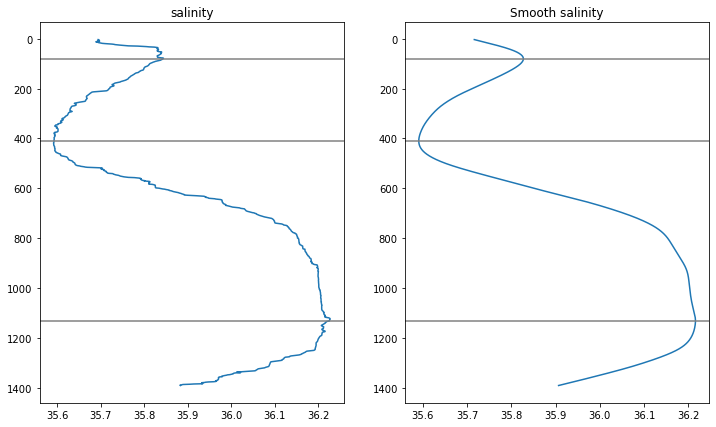

In [3]:
#Now we find those points where the 1st derivative is 0 (relative maximums and minimums)
ind_maxmin=[]
for i in range(len(der1_var_tend)):       #Loop that detects the 2 points that cross the deriv=0 and stores the indexs
    if i == (len(der1_var_tend)-1):
        break
    elif der1_var_tend[i]*der1_var_tend[i+1] < 0:      
        ind_maxmin.append(i)
        ind_maxmin.append(i+1)        
ind_maxmin = np.array(ind_maxmin).reshape(len(ind_maxmin)//2, 2)
print('there are ',len(ind_maxmin),' relative maximums and minimums in the next depths')

#Now we find the depths of those maxs/mins
pres_maxmin = []
for i in ind_maxmin:
    pressure = (data[ncast].index[i[0]]+data[ncast].index[i[1]])/2
    pres_maxmin.append(pressure)
print(pres_maxmin)

#Now we store the number of layers
nlayers = len(pres_maxmin)+1
print('Profile '+ncast+' has '+str(nlayers)+' layers')

#Now we plot the result of the profile with its layers
fig, (ax0, ax1) = plt.subplots(1,2,figsize=(12,7))
ax0.plot(data[ncast][variable], data[ncast].index)
ax0.invert_yaxis()
for i in pres_maxmin:
    ax0.axhline(y=i, c='grey')
ax0.set_title(variable)
ax1.plot(var_tend, data[ncast].index)
ax1.invert_yaxis()
for i in pres_maxmin:
    ax1.axhline(y=i, c='grey')
ax1.set_title('Smooth '+variable)
plt.show()

The file 'maxmin.py' stores a function that resumes this process and returns the number of layers of a particular profile without the plots ('maxmin' function) and with the plots ('maxmin_plot' function).

When we apply this approach to all the profiles, we observed that this approach did not detect as many layers as the first approach and that the results where coherent with what we expected. However, in some profiles it kept detecting too many layers (see below the profile ncast 15). 

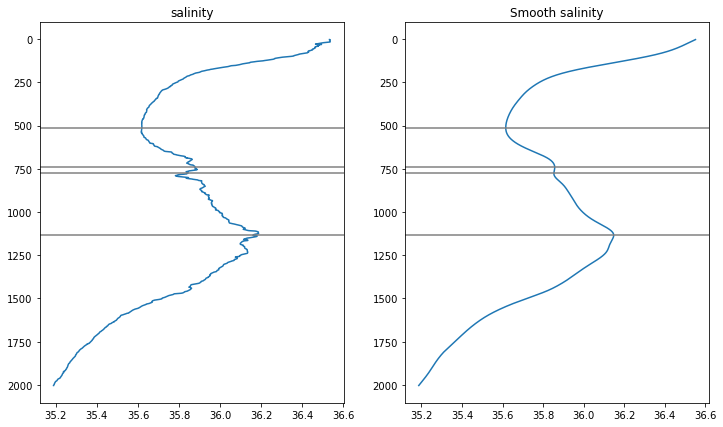

5

In [11]:
#Examples where the approach detects too many layers
from maxmin import maxmin_plot
maxmin_plot(data, '15', lamb=500000)

Thus, we created a variant that grouped the relative maximums or minimums that where closer than 50m (i.e.) and transformed them in just one maximum or minimum centered. This new approach improved made the results more coherent.

# 3rd Approach - Maxs/Mins 2nd version

In [12]:
#1st part is the same
#Test with ncast=15
ncast = '15'

#Smooth the profile
variable = 'salinity'
lamb = 500000    #Smooth exageration
var_ciclo, var_tend = sm.tsa.filters.hpfilter(data[ncast][variable],lamb=lamb)

#Calculate the 1st derivative of the smooth profile
der1_var_tend = np.diff(var_tend, n=1)

#Now we find those points where the 1st derivative is 0 (relative maximums and minimums)
ind_maxmin=[]
for i in range(len(der1_var_tend)):       #Loop that detects the 2 points that cross the deriv=0 and stores the indexs
    if i == (len(der1_var_tend)-1):
        break
    elif der1_var_tend[i]*der1_var_tend[i+1] < 0:      
        ind_maxmin.append(i)
        ind_maxmin.append(i+1)        
ind_maxmin = np.array(ind_maxmin).reshape(len(ind_maxmin)//2, 2)
print('there are ',len(ind_maxmin),' relative maximums and minimums in the next depths')

#Now we find the depths of those maxs/mins
pres_maxmin = []
for i in ind_maxmin:
    pressure = (data[ncast].index[i[0]]+data[ncast].index[i[1]])/2
    pres_maxmin.append(pressure)
print(pres_maxmin)

there are  4  relative maximums and minimums in the next depths
[511.8665, 741.2275, 775.6025, 1133.8435]


The following maxs/mins are too close
[[741.2275, 775.6025]]

We substitute them by the following max/min centered
[758.415]

These are our final maxs/mins:
[511.8665, 1133.8435, 758.415]



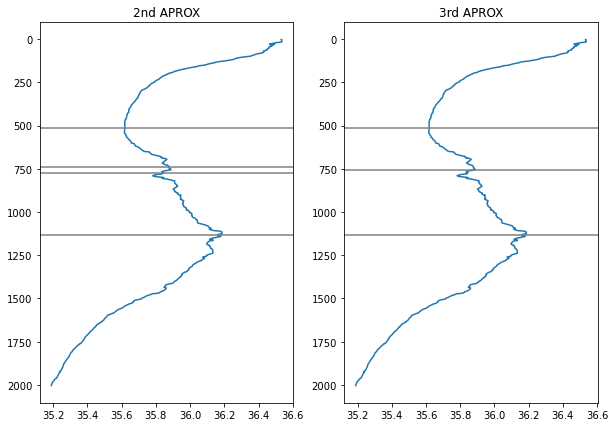

In [14]:
#PART 2
#(1)Select the maxs/mins closer than 50m
#(2)There may be different groups so we group them
#(3)Replace those maxs/mins with a new max/min centered

#Store the maxs/mins closer than 50m
pres = []
for i in range(len(pres_maxmin)):
    #print(i)
    if i == (len(pres_maxmin)-1):
        break
    elif (pres_maxmin[i+1]-pres_maxmin[i])<51:
        pres.append(pres_maxmin[i])
        pres.append(pres_maxmin[i+1])
pres = list(set(pres))
pres.sort()

#Group the maxs/mins closer than 50m
dif_pres = np.diff(pres)            #calculates the difference between maxs/mins
groups = []                         #indexs that separate the groups
for i in range(len(dif_pres)):
    if dif_pres[i] > 51:            #if the difference is bigger than 50, get the index
        groups.append(i)
pres_groups = []
if len(groups) == 0:                #If there is just 1 group all the pressures are stored
    pres_groups.append(pres)
if len(groups) == 1:                #If there are 2 groups the indexs are separated this way
    pres_i = []
    pres_i = pres[0:groups[0]+1]
    pres_groups.append(pres_i)
    pres_i = []
    pres_i = pres[groups[0]+1:]
    pres_groups.append(pres_i)
if len(groups) > 1:                     #If there are more than 2 groups, indexs are separated this way
    for i in range(len(groups)):
        if i == 0:
            pres_i = []
            pres_i = pres[0:groups[0]+1]
            pres_groups.append(pres_i)
        elif groups[i] == groups[-1]:
            pres_i = []
            pres_i = pres[groups[i-1]+1:groups[i]+1]
            pres_groups.append(pres_i)
            pres_i = []
            pres_i = pres[groups[-1]+1:]
            pres_groups.append(pres_i)       
        else:
            pres_i = []
            pres_i = pres[groups[i-1]+1:groups[i]+1]
            pres_groups.append(pres_i)
            
#Now we have the indexs separated by groups
#If there are no maxs/mins closer than 50m, we stop
if len(pres_groups) == 0:
    print('There are no maxs/mins closer than 50m')
    sys.exit()
#If there are maxs/mins closer than 50m, we continue
print('The following maxs/mins are too close')
print(pres_groups)
print()

#We delete the those maxs/mins and replace them by a new max/min centered
new_pres=[]
for i in pres_groups:
    pres_i = (i[0]+i[-1])/2
    new_pres.append(pres_i)
print('We substitute them by the following max/min centered')
print(new_pres)
print()

pres_maxmin2 = []
for i in pres_maxmin:
    pres_maxmin2.append(i)
for i in pres_groups:
    for pressure in i:
        pres_maxmin2.remove(pressure)
for i in new_pres:
    pres_maxmin2.append(i)
print('These are our final maxs/mins:')
print(pres_maxmin2)
print()

#Store the number of layers
ncapas2 = len(pres_maxmin2) +1

#Plot the results
fig, (ax0, ax1) = plt.subplots(1,2,figsize=(10,7))
ax0.plot(data[ncast][variable], data[ncast].index)
ax0.invert_yaxis()
for i in pres_maxmin:
    ax0.axhline(y=i, c='grey')
ax0.set_title('2nd APROX')
ax1.plot(data[ncast][variable], data[ncast].index)
ax1.invert_yaxis()
for i in pres_maxmin2:
    ax1.axhline(y=i, c='grey')
ax1.set_title('3rd APROX')
plt.show()


We observe that the 3rd approach would be a more coherent approach for this particular profile. However, I think that all this new approach could be solved applying more exageration into the profile smoothing. We will check it.

We add two functions named "maxmin_2" and "maxmin_2_plot" into the "maxmin.py" file that resumes this 3rd approach without and with plots, respectively.

